In [ ]:
install.packages(c('dplyr', 'tidytext', 'wordcloud2', 'topicmodels', 'tidyr',
                   'kableExtra', 'knitr', 'ggrepel', 'gridExtra', 'formattable', 'tm'), dependencies = TRUE, repos = "http://cran.us.r-project.org")

In [ ]:
packages <- c('dplyr', 'ggplot2', 'gridExtra', 'tidytext', 'wordcloud2', 'tm')
lapply(packages, library, character.only=TRUE)

In [3]:
library(tidytext) #text mining, unnesting
library(topicmodels) #the LDA algorithm
library(tidyr) #gather()
library(kableExtra) #create attractive tables
library(knitr) #simple table generator
library(ggrepel) #text and label geoms for ggplot2
library(gridExtra)
library(formattable) #color tile and color bar in `kables`

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows



# Lyric Analysis of Prince

In [241]:
prince_orig <- read.csv("prince_raw_data.csv", stringsAsFactors = FALSE)

In [242]:
prince <- prince_orig %>% 
  select(lyrics = text, song, year, album, peak, 
         us_pop = US.Pop, us_rnb = US.R.B)

glimpse(prince[139,])

Observations: 1
Variables: 7
$ lyrics <chr> "I just can't believe all the things people say, controversy...
$ song   <chr> "controversy"
$ year   <int> 1981
$ album  <chr> "Controversy"
$ peak   <int> 3
$ us_pop <chr> "70"
$ us_rnb <chr> "3"


In [243]:
# function to expand contractions in an English-language source
fix.contractions <- function(doc) {
  # "won't" is a special case as it does not expand to "wo not"
  doc <- gsub("won't", "will not", doc)
  doc <- gsub("can't", "can not", doc)
  doc <- gsub("n't", " not", doc)
  doc <- gsub("'ll", " will", doc)
  doc <- gsub("'re", " are", doc)
  doc <- gsub("'ve", " have", doc)
  doc <- gsub("'m", " am", doc)
  doc <- gsub("'d", " would", doc)
  # 's could be 'is' or could be possessive: it has no expansion
  doc <- gsub("'s", "", doc)
  return(doc)
}

# fix (expand) contractions
prince$lyrics <- sapply(prince$lyrics, fix.contractions)

In [244]:
# function to remove special characters
removeSpecialChars <- function(x) gsub("[^a-zA-Z0-9 ]", " ", x)

# remove special characters
prince$lyrics <- sapply(prince$lyrics, removeSpecialChars)

# convert everything to lower case
prince$lyrics <- sapply(prince$lyrics, tolower)

In [245]:
str(prince[139, ]$lyrics, nchar.max = 300)

 chr "i just can not believe all the things people say  controversy am i black or white  am i straight or gay  controversy do i believe in god  do i believe in me  controversy controversy  controversy i can not understand human curiosity  controversy was it good for you  was i what you wa"| __truncated__


##### Add a few fields

In [249]:
#create the decade column
prince <- prince %>%
  mutate(decade = 
           ifelse(prince$year %in% 1978:1979, "1970s", 
           ifelse(prince$year %in% 1980:1989, "1980s", 
           ifelse(prince$year %in% 1990:1999, "1990s", 
           ifelse(prince$year %in% 2000:2009, "2000s", 
           ifelse(prince$year %in% 2010:2015, "2010s", 
                  "NA"))))))

In [250]:
#create the chart level column
prince <- prince %>%
  mutate(chart_level = 
           ifelse(prince$peak %in% 1:10, "Top 10", 
           ifelse(prince$peak %in% 11:100, "Top 100", "Uncharted")))

In [251]:
#create binary field called charted showing if a song hit the charts at all
prince <- prince %>%
  mutate(charted = 
           ifelse(prince$peak %in% 1:100, "Charted", "Uncharted"))

#save the new dataset to .csv for use in later tutorials
write.csv(prince, file = "prince_new.csv")

In [252]:
#define some colors to use throughout
my_colors <- c("#E69F00", "#56B4E9", "#009E73", "#CC79A7", "#D55E00")

theme_lyrics <- function() 
{
  theme(plot.title = element_text(hjust = 0.5),
        axis.text.x = element_blank(), 
        axis.ticks = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "none")
}

##### Song Stats

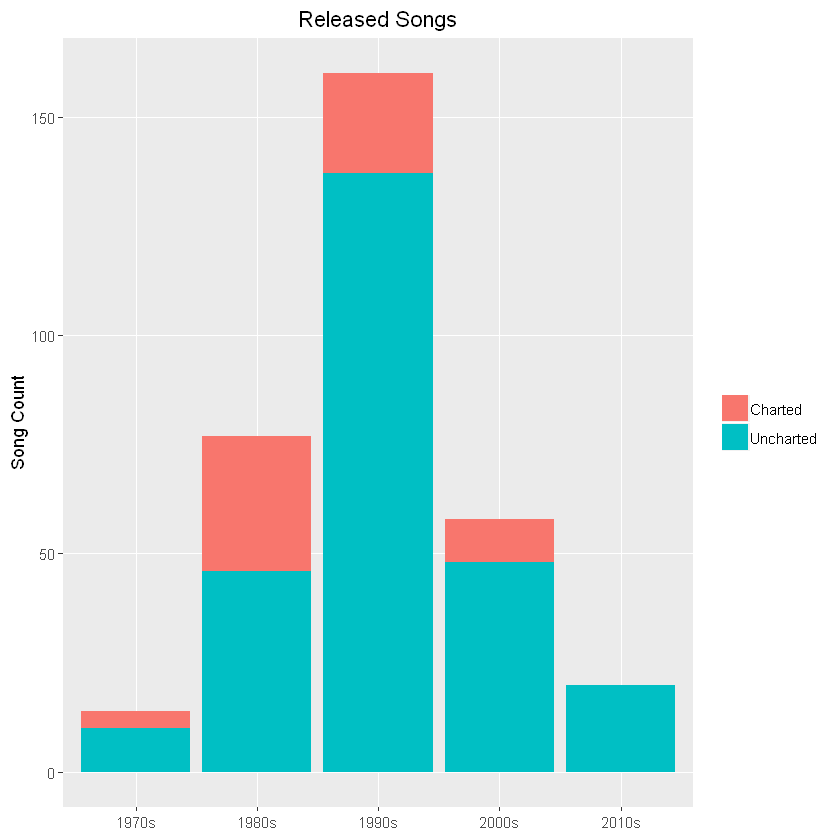

In [253]:
prince %>%
  filter(decade != "NA") %>%
  group_by(decade, charted) %>%
  summarise(number_of_songs = n()) %>%
  ggplot() + 
  geom_bar(aes(x = decade, y = number_of_songs, 
               fill = charted), stat = "identity")  +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        panel.grid.minor = element_blank()) +
  ggtitle("Released Songs") +
  labs(x = NULL, y = "Song Count")

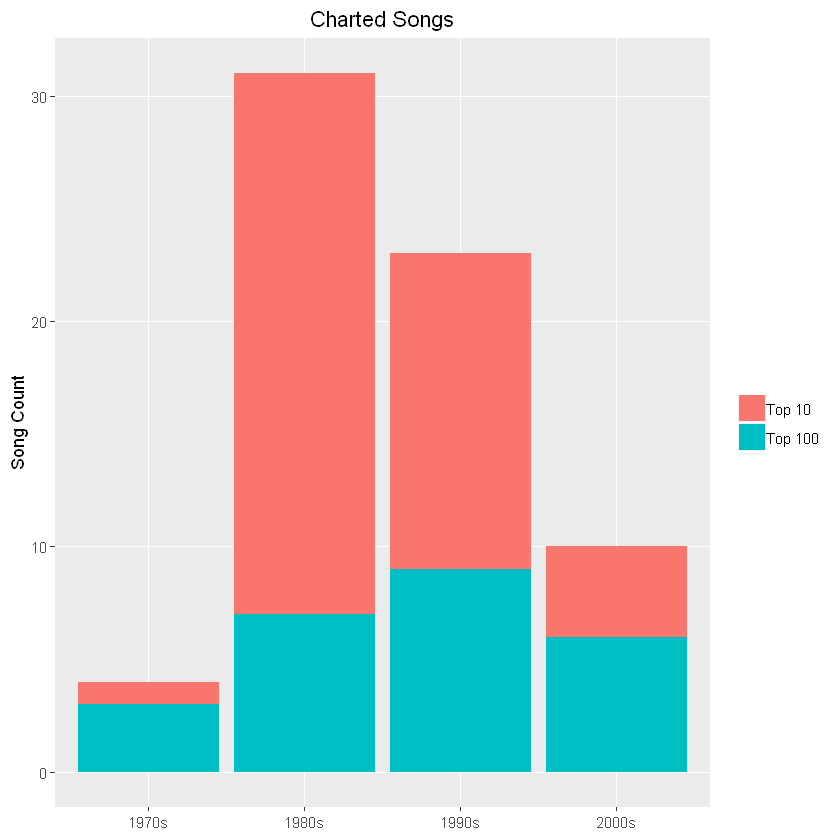

In [254]:
charted_songs_over_time <- prince %>%
  filter(peak > 0) %>%
  group_by(decade, chart_level) %>%
  summarise(number_of_songs = n())

charted_songs_over_time %>% 
  ggplot() + 
  geom_bar(aes(x = decade, y = number_of_songs, 
               fill = chart_level), stat = "identity") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        panel.grid.minor = element_blank()) +
  labs(x = NULL, y = "Song Count") +
  ggtitle("Charted Songs")

In [247]:
undesirable_words <- c("prince", "chorus", "repeat", "lyrics", 
                       "theres", "bridge", "fe0f", "yeah", "baby", 
                       "alright", "wanna", "gonna", "chorus", "verse", 
                       "whoa", "gotta", "make", "miscellaneous", "2", 
                       "4", "ooh", "uurh", "pheromone", "poompoom", "3121", 
                       "matic", " ai ", " ca ", " la ", "hey", " na ", 
                       " da ", " uh ", " tin ", "  ll", "transcription",
                       "repeats")

In [255]:
#unnest and remove stop, undesirable and short words
prince_words_filtered <- prince %>%
  unnest_tokens(word, lyrics) %>%
  anti_join(stop_words) %>%
  distinct() %>%
  filter(!word %in% undesirable_words) %>%
  filter(nchar(word) > 3)

Joining, by = "word"


In [256]:
 prince_words_filtered %>% 
  filter(word == "race") %>%
  select(word, song, year, peak, decade, chart_level, charted) %>%
  arrange() %>%
  top_n(10,song) %>%
  mutate(song = color_tile("lightblue","lightblue")(song)) %>%
  mutate(word = color_tile("lightgreen","lightgreen")(word)) %>%
  kable("html", escape = FALSE, align = "c", caption = "Tokenized Format Example") %>%
  kable_styling(bootstrap_options = 
                  c("striped", "condensed", "bordered"), 
                  full_width = FALSE)

Warning message in gradient(as.numeric(x), ...):
"NAs introduced by coercion"Warning message in gradient(as.numeric(x), ...):
"NAs introduced by coercion"

<table class="table table-striped table-condensed table-bordered" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>Tokenized Format Example</caption>
 <thead>
  <tr>
   <th style="text-align:center;"> word </th>
   <th style="text-align:center;"> song </th>
   <th style="text-align:center;"> year </th>
   <th style="text-align:center;"> peak </th>
   <th style="text-align:center;"> decade </th>
   <th style="text-align:center;"> chart_level </th>
   <th style="text-align:center;"> charted </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:center;"> <span style="display: block; padding: 0 4px; border-radius: 4px; background-color: #90ee90">race</span> </td>
   <td style="text-align:center;"> <span style="display: block; padding: 0 4px; border-radius: 4px; background-color: #add8e6">lovesexy              </span> </td>
   <td style="text-align:center;"> 1988 </td>
   <td style="text-align:center;"> 1 </td>
   <td style="text-align:center;"> 198

# Loading original dataset

In [4]:
lyrics_dataset_orig <- read.csv('lyrics.csv', stringsAsFactors = FALSE)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
"EOF within quoted string"

In [5]:
names(lyrics_dataset_orig)

[1] "index"  "song"   "year"   "artist" "genre"  "lyrics"

In [6]:
dim(lyrics_dataset_orig)

[1] 339277      6

In [7]:
lyrics_dataset_orig[lyrics_dataset_orig == ''] <- NA

In [8]:
lyrics_dataset_orig <- na.omit(lyrics_dataset_orig, cols = 'song')
lyrics_dataset_orig <- na.omit(lyrics_dataset_orig, cols = 'genre')
lyrics_dataset_orig <- na.omit(lyrics_dataset_orig, cols = 'lyrics')
lyrics_dataset_orig <- na.omit(lyrics_dataset_orig, cols = 'year')

In [9]:
dim(lyrics_dataset_orig)

[1] 249828      6

In [10]:
glimpse(lyrics_dataset_orig[16308, ])

Observations: 1
Variables: 6
$ index  <int> 22821
$ song   <chr> "for-the-music"
$ year   <int> 2013
$ artist <chr> "grapefruit-sound-lab"
$ genre  <chr> "Not Available"
$ lyrics <chr> "We came here for the music\nWe came here for the sound\nWe'...


In [11]:
unique(lyrics_dataset_orig$genre)

[1] "Pop"           "Hip-Hop"       "Not Available" "Rock"         
 [5] "Metal"         "Other"         "Country"       "Jazz"         
 [9] "Electronic"    "Folk"          "R&B"           "Indie"

##### Selecting 5000 songs from each genre

In [290]:
pop <- sample_n(subset(lyrics_dataset_orig, genre == 'Pop'), 5000)
rock <- sample_n(subset(lyrics_dataset_orig, genre == 'Rock'), 5000)
jazz <- sample_n(subset(lyrics_dataset_orig, genre == 'Jazz'), 5000)
hiphop <- sample_n(subset(lyrics_dataset_orig, genre == 'Hip-Hop'), 5000)
country <- sample_n(subset(lyrics_dataset_orig, genre == 'Country'), 5000)

In [291]:
lyrics_dataset <- rbind(pop, rock, jazz, hiphop, country)

In [292]:
dim(lyrics_dataset)

[1] 25000     6

In [293]:
sample(lyrics_dataset, 5)

index,year,artist,lyrics,genre
12613,2009,butterfly-boucher,"You know that feeling Bright red and seizing Every word that you said (Did you mean it Did you mean it all?) There it goes to my head (You be careful It's contagious, boy) But it feels so good It's just wires Smoke and mirrors and flowers Help! And throw me a rope I think I'm drowning Shallow people Help! I think I'm falling, falling again You know that feeling Bright red and seizing When you'd like to be seen (Did you see her? Did you see her hair?) Would you like to told (You look gorgeous, simply gorgeous) We like to be heard (Did you hear her? Did she say something charming?) Help! And throw me a rope I think I'm drowning Help! I think I'm falling, falling again Breathe in Breathe out And sigh And sigh Help! And throw me a rope I think I'm drowning (drowning) Face down Help! Oh, help No more falling for tall tales again Still falling for shallow people Help! Help! I think I'm falling again You know the feeling Time to believe it",Pop
14038,2007,andy-williams,"May each day in the week be a good day May the Lord always watch over you And may all of your hopes turn to wishes And may all of your wishes come true May each day in the month be a good day May you make friends with each one you meet And may all of your daydreams be mem'ries And may all of your mem'ries be sweet The weeks turn to months and the months into years There'll be sadness and joy, there'll be laughter and tears But one thing I pray to heaven above May each of your days be a day full of love May each day in the year be a good day May each dawn find you happy and gay And may all of your days be as lovely As the one you shared with me today",Pop
130906,2006,abba,"Went to buy me a paper at the local news-stand And then I heard them laugh and say Look, they're gonna go flying way up to the moon now Hey, what's it good for anyway? So I said Fellas, like to ask you a thing if I may What about Livingstone? What about all those men? Who have sacrificed their lives to lead the way Tell me, wasn't it worth the while Traveling up the Nile Putting themselves on test Didn't that help the rest? Wasn't it worth it then? What about Livingstone? And all of those fellas at the local news-stand Didn't know what to answer or what to say So I told them about him, that he was just like One of those spacemen in his way And if you laugh at them Then there's only a thing I can say What about Livingstone? What about all those men? Who have sacrificed their lives to lead the way Tell me, wasn't it worth the while Traveling up the Nile Putting themselves on test Didn't that help the rest? Wasn't it worth it then?",Pop
115271,2007,alex-parks,"Sleep is hard, I'm tired Fall into sleep in your wide eyes I can only dream I can only see if you want me to see, but I I can only chase I will only chase the blue, if I've seen the blue, in your eyes That was my surprise from you, your eyes Gave me all I needed from you Be here holding you Makes me feel like I got something to do But you're already reaching for the sky We can only dream We can only see if you want us to see, but I I can only chase I will only chase the blue, if I've seen the blue, in your eyes That was my surprise from you, your eyes Gave me all I needed from you",Pop
85425,2007,aztec-camera,"Our love's the sound Of broken skies Too blind to see What lies inside We love what shines Before our eyes Why can't we learn What hides? Waiting on the last train Flicking through the highlights Livin' in a suitcase Positively uptight Kissing in the full moon Drowning in the sunshine Walking on a tightrope And everything is gonna be just fine 'cause I believe in your heart of gold Automatically sunshine Yeah glitter, glitter everywhere Like working in a goldmine And we believe that there's a heart beats on In the dark of the close down Yeah glitter, glitter everywhere Like working in a goldmine And time not tied Is time to feed We lose our pride We spill our seed The worst of us E

In [294]:
lyrics <- lyrics_dataset %>%
        select(song, lyrics, genre)
glimpse(lyrics[1310, ])

Observations: 1
Variables: 3
$ song   <chr> "boyfriend-material"
$ lyrics <chr> "Now I've been looking for someone\nTrying to find the right...
$ genre  <chr> "Pop"


##### Basic Cleaning

In [295]:
# function to expand contractions in an English-language source
fix.contractions <- function(doc) {
  # "won't" is a special case as it does not expand to "wo not"
  doc <- gsub("won't", "will not", doc)
  doc <- gsub("can't", "can not", doc)
  doc <- gsub("n't", " not", doc)
  doc <- gsub("'ll", " will", doc)
  doc <- gsub("'re", " are", doc)
  doc <- gsub("'ve", " have", doc)
  doc <- gsub("'m", " am", doc)
  doc <- gsub("'d", " would", doc)
  # 's could be 'is' or could be possessive: it has no expansion
  doc <- gsub("'s", "", doc)
  return(doc)
}

# fix (expand) contractions
lyrics$lyrics <- sapply(lyrics$lyrics, fix.contractions)

In [296]:
glimpse(lyrics[1, ])

Observations: 1
Variables: 3
$ song   <chr> "bright-red"
$ lyrics <chr> "You know that feeling\nBright red and seizing\nEvery word t...
$ genre  <chr> "Pop"


In [297]:
# function to remove special characters
removeSpecialChars <- function(x) gsub("[^a-zA-Z0-9 ]", " ", x)
# remove special characters
lyrics$lyrics <- sapply(lyrics$lyrics, removeSpecialChars)

In [298]:
# convert everything to lower case
lyrics$lyrics <- sapply(lyrics$lyrics, tolower)

In [299]:
#unnest and remove stop and short words
lyrics_words_filtered <- lyrics %>%
  unnest_tokens(word, lyrics) %>%
  anti_join(stop_words) %>%
  distinct() %>%
  filter(nchar(word) > 3)

Joining, by = "word"


In [300]:
glimpse(lyrics[1, ])

Observations: 1
Variables: 3
$ song   <chr> "bright-red"
$ lyrics <chr> "you know that feeling bright red and seizing every word tha...
$ genre  <chr> "Pop"


In [301]:
dim(lyrics_words_filtered)

[1] 1217990       3

In [303]:
#group the dataset by writer (source) and count the words
lyrics_words_filtered %>%
  group_by(genre) %>%
  mutate(word_count = n()) %>%
  select(genre, word_count) %>% #only need these fields
  distinct() %>%
  ungroup() %>%
  #assign color bar for word_count that varies according to size
  #create static color for source and genre
  mutate(word_count = (word_count),
         genre = (genre)) %>%
  print(word_count)

# A tibble: 5 x 2
  genre   word_count
  <chr>        <int>
1 Pop         188589
2 Rock        178459
3 Jazz        134663
4 Hip-Hop     551196
5 Country     165083


In [304]:
lyrics_words_filtered <- lyrics_words_filtered %>%
                        unite(song_genre, song, genre)

In [305]:
sample(lyrics_words_filtered)
# lyrics_words_filtered[lyrics_words_filtered == 'rivers-of-babylon']

word,song_genre
feeling,bright-red_Pop
bright,bright-red_Pop
seizing,bright-red_Pop
word,bright-red_Pop
head,bright-red_Pop
careful,bright-red_Pop
contagious,bright-red_Pop
feels,bright-red_Pop
wires,bright-red_Pop
smoke,bright-red_Pop


In [306]:
lyrics_words_dtm_filtered <- lyrics_words_filtered %>%
  #get word count per document to pass to cast_dtm
  count(song_genre, word, sort = TRUE) %>%
  ungroup() %>%
  #create a DTM with docs as rows and words as columns
  cast_dtm(song_genre, word, n)
#examine the structure of the DTM
lyrics_words_dtm_filtered

<<DocumentTermMatrix (documents: 23061, terms: 100311)>>
Non-/sparse entries: 1217990/2312053981
Sparsity           : 100%
Maximal term length: 58
Weighting          : term frequency (tf)

In [307]:
inspect(lyrics_words_dtm_filtered[1:4,1:8])

<<DocumentTermMatrix (documents: 4, terms: 8)>>
Non-/sparse entries: 8/24
Sparsity           : 75%
Maximal term length: 9
Weighting          : term frequency (tf)
Sample             :
                                 Terms
Docs                              abdu accident ache acid adding afar answers
  0-to-100-freestyle_Hip-Hop         1        1    1    1      1    1       1
  008_Rock                           0        0    0    0      0    0       0
  1-000-000-years-from-today_Jazz    0        0    0    0      0    0       0
  1-2-3_Hip-Hop                      0        0    0    0      0    0       0
                                 Terms
Docs                              backpacks
  0-to-100-freestyle_Hip-Hop              1
  008_Rock                                0
  1-000-000-years-from-today_Jazz         0
  1-2-3_Hip-Hop                           0


In [308]:
genre_dtm <- lyrics_words_dtm_filtered
genre_tidy <- lyrics_words_filtered

In [309]:
k <- 5 #number of topics
seed = 1234 #necessary for reproducibility
#fit the model passing the parameters discussed above
#you could have more control parameters but will just use seed here
lda <- LDA(genre_dtm, k = k, method = "GIBBS", control = list(seed = seed))
#examine the class of the LDA object
class(lda)

[1] "LDA_Gibbs"
attr(,"package")
[1] "topicmodels"

In [310]:
#convert the LDA object into a tidy format
#passing "beta" shows the word probabilities
#filter on the word iceberg as an example
#results show probability of iceberg for each topic
tidy(lda, matrix = "beta") %>% filter(term == "rivers")

topic,term,beta
1,rivers,2.744854e-07
2,rivers,1.758915e-04
3,rivers,2.299517e-05
4,rivers,1.381206e-04
5,rivers,3.967197e-05


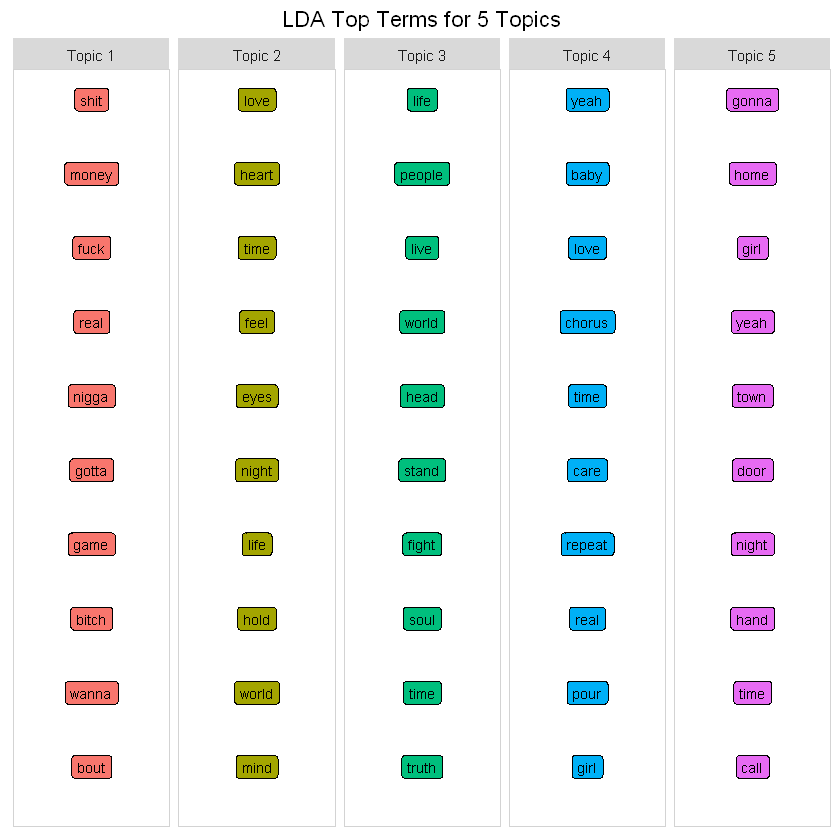

In [311]:
num_words <- 10 #number of words to visualize

#create function that accepts the lda model and num word to display
top_terms_per_topic <- function(lda_model, num_words) {

  #tidy LDA object to get word, topic, and probability (beta)
  topics_tidy <- tidy(lda_model, matrix = "beta")


  top_terms <- topics_tidy %>%
  group_by(topic) %>%
  arrange(topic, desc(beta)) %>%
  #get the top num_words PER topic
  slice(seq_len(num_words)) %>%
  arrange(topic, beta) %>%
  #row is required for the word_chart() function
  mutate(row = row_number()) %>%
  ungroup() %>%
  #add the word Topic to the topic labels
  mutate(topic = paste("Topic", topic, sep = " "))
  #create a title to pass to word_chart
  title <- paste("LDA Top Terms for", k, "Topics")
  #call the word_chart function you built in prep work
  word_chart(top_terms, top_terms$term, title)
}
#call the function you just built!
top_terms_per_topic(lda, num_words)

In [312]:
#this time use gamma to look at the prob a doc is in a topic
#just look at the Prince song 1999 as an example
tidy(lda, matrix = "gamma") %>% filter(document == "rivers-of-babylon_Pop")
# tidy(lda, matrix = "gamma") %>% filter(document == "if-god-can-forgive-me-why-can-t-you")

document,topic,gamma


In [313]:
songs_gamma <- tidy(lda, matrix = 'gamma')
head(songs_gamma)
# songs_gamma[songs_gamma == 'angel']
# class(songs_gamma)
dim(songs_gamma)

document,topic,gamma
0-to-100-freestyle_Hip-Hop,1,0.5420875
008_Rock,1,0.1134021
1-000-000-years-from-today_Jazz,1,0.2037037
1-2-3_Hip-Hop,1,0.5666667
1-2-conductor_Rock,1,0.2250000
1-2-the-3_Hip-Hop,1,0.5981735


[1] 115305      3

In [314]:
songs_gamma <- songs_gamma %>% separate(document, c('song', 'genre'), sep = '_', convert = TRUE)
songs_gamma

song,genre,topic,gamma
0-to-100-freestyle,Hip-Hop,1,0.54208754
008,Rock,1,0.11340206
1-000-000-years-from-today,Jazz,1,0.20370370
1-2-3,Hip-Hop,1,0.56666667
1-2-conductor,Rock,1,0.22500000
1-2-the-3,Hip-Hop,1,0.59817352
1-2,Country,1,0.28455285
1-9-9-9,Hip-Hop,1,0.41422594
1-900-sheila,Country,1,0.16666667
1-fan,Pop,1,0.19736842


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


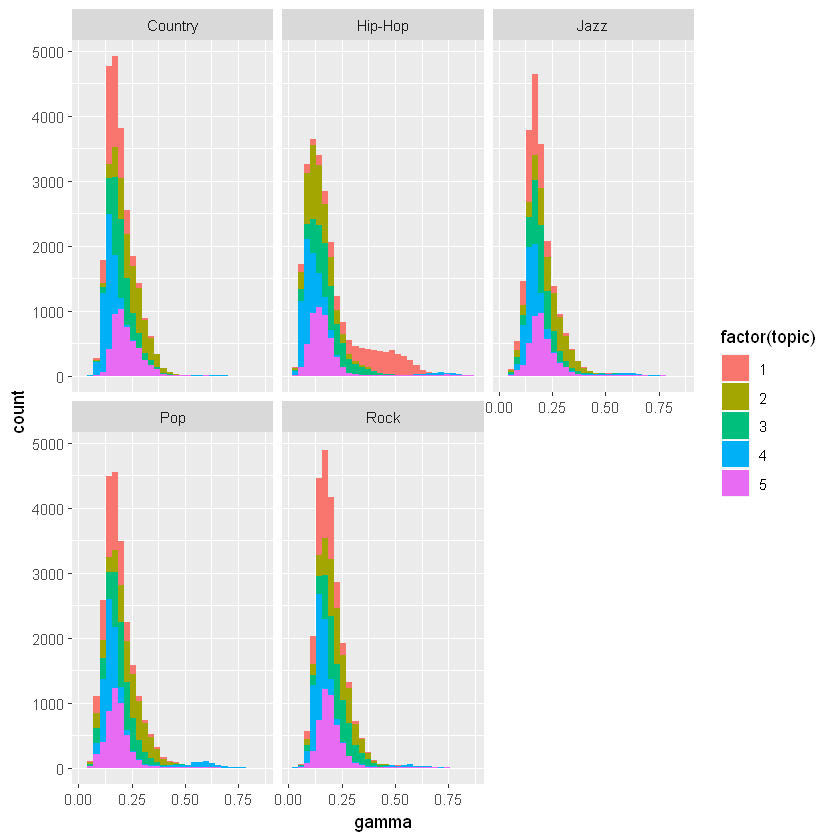

In [315]:
ggplot(songs_gamma, aes(gamma, fill = factor(topic))) +
  geom_histogram() +
  facet_wrap(~ genre, nrow = 2)

In [316]:
song_classifications <- songs_gamma %>%
  group_by(genre, song) %>%
  top_n(1, gamma) %>%
  ungroup() %>%
  arrange(gamma)

song_classifications

song,genre,topic,gamma
best-thing-for-you,Jazz,1,0.2037037
i-be-blowin,Hip-Hop,1,0.2037037
say-something-new,Pop,1,0.2037037
three-cowboys,Rock,1,0.2037037
best-thing-for-you,Jazz,2,0.2037037
say-something-new,Pop,2,0.2037037
three-cowboys,Rock,2,0.2037037
best-thing-for-you,Jazz,3,0.2037037
i-be-blowin,Hip-Hop,3,0.2037037
say-something-new,Pop,3,0.2037037


In [317]:
song_genre <- song_classifications %>%
  count(genre, topic) %>%
  group_by(topic) %>%
  top_n(1, n) %>%
  ungroup() %>%
  transmute(consensus = genre, topic)

song_genre

consensus,topic
Country,2
Country,5
Hip-Hop,1
Pop,4
Rock,3


In [318]:
song_classifications_counts <- song_classifications %>%
  inner_join(song_genre, by = "topic") %>%
  count(genre, consensus)
song_classifications_counts

genre,consensus,n
Country,Country,3873
Country,Hip-Hop,241
Country,Pop,52
Country,Rock,781
Hip-Hop,Country,577
Hip-Hop,Hip-Hop,3461
Hip-Hop,Pop,242
Hip-Hop,Rock,613
Jazz,Country,2958
Jazz,Hip-Hop,288


In [319]:
# sum(song_classifications_counts$n)
misclassified = 0
for(i in 1:nrow(song_classifications_counts)) {
    if(song_classifications_counts$genre[i] != song_classifications_counts$consensus[i]) {
        misclassified = misclassified + song_classifications_counts$n[i]
    }
}

In [320]:
misclassified/(sum(song_classifications_counts$n))

[1] 0.5999918

In [174]:
sum(song_classifications_counts$n)

[1] 21941